In [1]:
!apt-get install -y tesseract-ocr
!apt-get install -y poppler-utils
%pip install pytesseract opencv-python-headless pdf2image PyMuPDF opencv-python-headless pytesseract pdf2image matplotlib numpy pillow pymupdf json5

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
Note: you may need to restart the kernel to use updated packages.


In [1]:
import cv2
import cv2
import pytesseract
from pdf2image import convert_from_path
from matplotlib import pyplot as plt
import numpy as np
import re
from PIL import Image
import fitz
import io
import json
from pprint import pprint

# TESSERACT CONFIG
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'


In [2]:
###################################################
### SET THE CONFIDENCES TO THE SETS OF KEYWORDS ###
###################################################

'''
Cada documento va a tener 3 tipos de palabras clave
  - Univocas: Palabras o secuencias de palabras que hacen univoco al documento (Tiene que ser extremadamente preciso, experimental)
  - Altas: Palabras que practicamente hacen decisivo al documento y tienen un valor alto de confianza, deben ser pocas y la sumatoria (max 2) dar 0.7 de confianza
  - Medias: Palabras que tienen un valor medio de confianza. Con encontrar 4 o 5 o N palabras deberia llegar a 0.2
  - Bajas: Palabras que tienen un valor bajo de confianza. Con encontrar 6 o 7 o N palabras deberia llegar a 0.1

De esta manera sin las palabras clave es imposible que los acepte
Se necesita cumplir con el cupo de palabras medias o bajas o una suma de ambas si o si
 '''

''' key_words_str = {
    "high_prior": [],
    "medium_prior": ["documento", "document","mercosur"],
    "low_prior": ["republica", "argentina", "registro", "nacional",
                "personas", "ministerio", "interior", "transporte", "sexo",
                "nombre", "nacionalidad", "tramite", "ejemplar"]
}


key_words_regex = {
    "high_prior": [r"(?i)IDARG"],
    "medium_prior": [r"\b\d{1,4}\.\d{3}\.\d{3}\b"],
    "low_prior": []
} '''

''' #path_key_words = "/content/drive/MyDrive/BACSSA/OCR/dni_key_words.json"
path_key_words = "/content/drive/MyDrive/BACSSA/OCR/licecond_key_words.json"
with open(path_key_words, "r") as file:
  data = json.load(file)

key_words_str = data["key_words_str"]
key_words_regex = data["key_words_regex"]
amount_key_words = {
      "high_prior": len(key_words_str["high_prior"])+len(key_words_regex["high_prior"]),
      "medium_prior": len(key_words_str["medium_prior"])+len(key_words_regex["medium_prior"]),
      "low_prior": len(key_words_str["low_prior"])+len(key_words_regex["low_prior"])
      }


# Confidence values for each class
high_conf=0.7
medium_conf=0.2
low_conf=0.1 '''

# Confidence values for each class
high_conf=0.7
medium_conf=0.2
low_conf=0.1

def confidence_assign(key_words, confidence, is_regex=False):
  key_words_with_confidence = {}
  for word in key_words:
    if(is_regex):
      word= re.compile(word)
    key_words_with_confidence[word] = confidence
  return key_words_with_confidence

def make_load(key_words, is_regex=False, class_confidence={}, amount_key_words=0):
  for key_name, key_words_values in key_words.items():
    if key_name == "high_prior":
      assign_conf= class_confidence["high_conf"]
    if key_name == "medium_prior":
      assign_conf=  class_confidence["medium_conf"]
    if key_name == "low_prior":
      assign_conf = class_confidence["low_conf"]

    word_confidence = assign_conf/amount_key_words[key_name] # The sum of the words confidence has to be equals to the class confidence
    key_words[key_name] = confidence_assign(key_words_values, word_confidence, is_regex)
  return key_words

def load_confidences(key_words_str, key_words_regex, class_confidence, amount_key_words):
# Calculate the amount of words+regex to after calculate the efective confidence for every word/regex


  key_words_str_conf = make_load(key_words_str,False, class_confidence, amount_key_words)
  key_words_regex_conf = make_load(key_words_regex, True, class_confidence, amount_key_words)

  # Delete the name of priorities and make a single set
  key_words_str_conf = {**key_words_str_conf['high_prior'], **key_words_str_conf['medium_prior'], **key_words_str_conf['low_prior']}
  key_words_regex_conf = {**key_words_regex_conf['high_prior'], **key_words_regex_conf['medium_prior'], **key_words_regex_conf['low_prior']}
  return key_words_str_conf, key_words_regex_conf

''' # Set the confidence values
key_words_str_confidence, key_words_regex_confidence= load_confidences(key_words_str, key_words_regex)
print(key_words_str_confidence)
print(key_words_regex_confidence) '''





' # Set the confidence values\nkey_words_str_confidence, key_words_regex_confidence= load_confidences(key_words_str, key_words_regex)\nprint(key_words_str_confidence)\nprint(key_words_regex_confidence) '

In [ ]:
###########################
### MODEL WITH FULL PDF ###
###########################
# PDF PATH
# pdf_path = '/content/sample_data/ManuelLatorreDNIFrente.pdf'
#pdf_path = '/content/drive/MyDrive/BACSSA/OCR/doble.pdf'
#pdf_path = '/content/drive/MyDrive/BACSSA/OCR/licecond.pdf'



def get_color(word_or_regex, key_words_str, key_words_regex):

    color_in=(0, 0, 0)
    if word_or_regex in key_words_str['high_prior'] or word_or_regex in key_words_regex['high_prior']: color_in=(0, 0, 255)
    if word_or_regex in key_words_str['medium_prior'] or word_or_regex in key_words_regex['medium_prior']: color_in=(0, 165, 255)
    if word_or_regex in key_words_str['low_prior'] or word_or_regex in key_words_regex['low_prior'] : color_in=(0, 255, 0)
    return color_in

def analize_pdf(pdf_paths, key_words_str, key_words_regex, key_words_str_confidence, key_words_regex_confidence, key_word_path_name):
  results_pdf = {}
  results = {}
  for pdf_path in pdf_paths:
    printed_pages=[]
    # CONVERT FROM PDF TO A LIST OF IMAGES, ONE IMAGE PER PAGE
    pages = convert_from_path(pdf_path)
    sum_confidence=0

    # PROCESS BY PAGE
    finded_words = set()

    for page_number, page in enumerate(pages):
      # CONVERT TO BGR FOR OPENCV
      page_img = cv2.cvtColor(np.array(page), cv2.COLOR_RGB2BGR)

      # GRAY SCALE
      gray = cv2.cvtColor(page_img, cv2.COLOR_BGR2GRAY)

      # DETECT WORDS AND GET POSITIONS
      detection_data = [
          pytesseract.image_to_data(page_img, output_type=pytesseract.Output.DICT),
          pytesseract.image_to_data(gray, output_type=pytesseract.Output.DICT)
      ]

      for detection in detection_data:
        for i in range(len(detection['text'])):
          word = detection['text'][i].strip().lower()  # To lower case
          # Check strings
          if word in key_words_str_confidence:
            color_str= get_color(word, key_words_str, key_words_regex)
            if word not in finded_words:
              #my_word = f"{word}: {key_words_str_confidence[word]}"
              #print("FINDED WORDS:",finded_words," MYWORD: ",my_word)
              finded_words.add(word)
              sum_confidence+=key_words_str_confidence[word]
            # DRAW BOX AROUND KEYWORD
            x, y, w, h = detection['left'][i], detection['top'][i], detection['width'][i], detection['height'][i]
            page_img = cv2.rectangle(page_img, (x, y), (x + w, y + h), color_str, 2)

          # Check regex
          for regex, regex_conf in key_words_regex_confidence.items():
            match_regex= re.search(regex, word)
            if match_regex:
              color_reg= get_color(regex, key_words_str, key_words_regex)
              regex_word = match_regex.group(0)
              if regex_word not in finded_words:
                my_word = f"{regex}: {regex_conf}"
                finded_words.add(regex_word)
                sum_confidence+=regex_conf
              # Draw box around regex
              x, y, w, h = detection['left'][i], detection['top'][i], detection['width'][i], detection['height'][i]
              page_img = cv2.rectangle(page_img, (x, y), (x + w, y + h), color_reg, 2)

        # Print the pdf with the boxes
        if page_number not in printed_pages:
          # CONVERT FROM BGR TO RGB TO SHOW WITH MATPLOTLIB
          img_rgb = cv2.cvtColor(page_img, cv2.COLOR_BGR2RGB)
          # SHOW IMAGE
          plt.figure(figsize=(5,5))
          plt.imshow(img_rgb)
          plt.title(f'Página {page_number + 1}')
          plt.axis('off')
          plt.show()
          print()
          printed_pages.append(page_number)


    # Set the result confidence for the key_word_path
    if page_number == len(pages)-1:
      results_pdf[pdf_path] = sum_confidence
      print()

  results[key_word_path_name] = results_pdf # {dni: {path_pdf_1: 0.xx, path_pdf_2: 0.xx}, lic_conducir: {path_pdf_1: 0.xx, path_pdf_2: 0.xx}}
  return results


BUSCANDO: dni


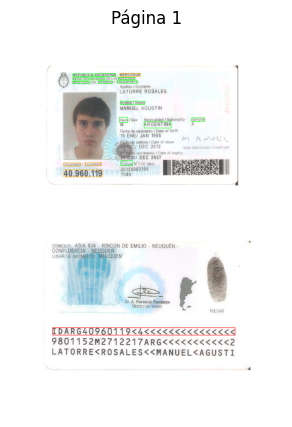

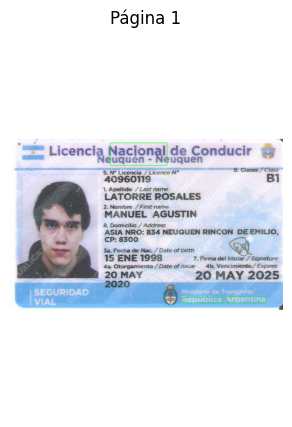

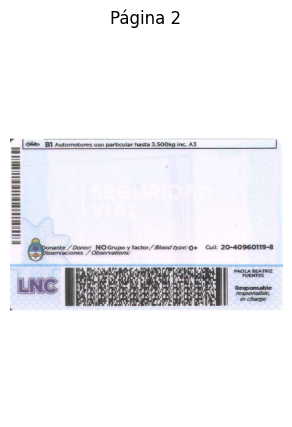

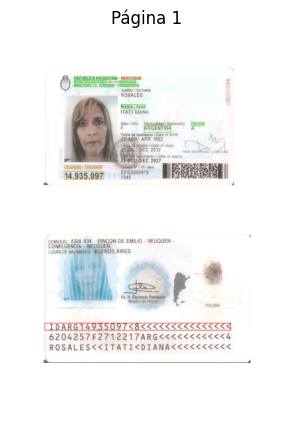



BUSCANDO: licencia_conducir


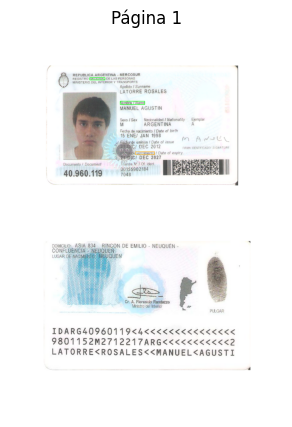

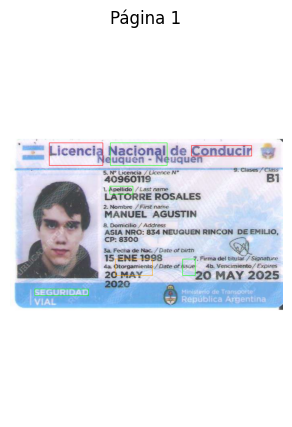

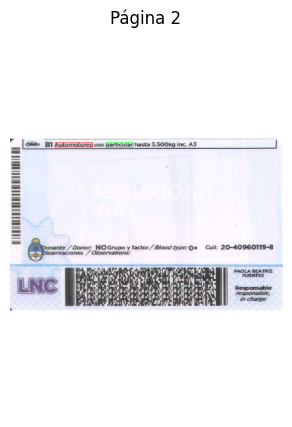

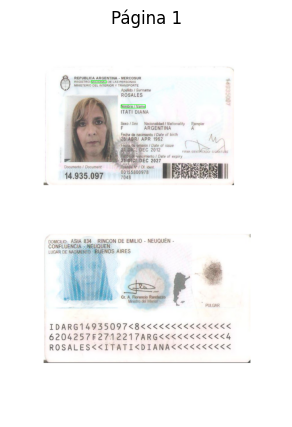

In [15]:
############
### MAIN ###
############

# Pdf Paths
doc = '/home/manuel/bacssa/orm/doble.pdf'
lice_cond = '/home/manuel/bacssa/orm/licecond.pdf'
ita_doc_key_words = "/home/manuel/bacssa/orm/Documento_ITA.pdf"
pdf_paths=[doc, lice_cond, ita_doc_key_words]

# KeyWords paths
doc_key_words = "/home/manuel/bacssa/orm/dni_key_words.json"

lice_key_words = "/home/manuel/bacssa/orm/licecond_key_words.json"
key_words_paths = {
    "dni": doc_key_words,
    "licencia_conducir": lice_key_words}

# Confidence values for each class
class_confidence= {
  "high_conf": 0.7,
  "medium_conf": 0.2,
  "low_conf": 0.1
}

# threshold
threshold = 0.9

results=[]
# The iterations go through each keyword list and check every PDF
for key_words_path_name, path in key_words_paths.items():
  with open(path, "r") as file:
    data = json.load(file)

  key_words_str = data["key_words_str"]
  key_words_regex = data["key_words_regex"]
  amount_key_words = {
        "high_prior": len(key_words_str["high_prior"])+len(key_words_regex["high_prior"]),
        "medium_prior": len(key_words_str["medium_prior"])+len(key_words_regex["medium_prior"]),
        "low_prior": len(key_words_str["low_prior"])+len(key_words_regex["low_prior"])
        }
  # Set the confidence values
  key_words_str_confidence, key_words_regex_confidence= load_confidences(key_words_str, key_words_regex, class_confidence, amount_key_words)

  # Call to analize pdf
  print("BUSCANDO:", key_words_path_name)
  results.append(analize_pdf(pdf_paths, key_words_str, key_words_regex, key_words_str_confidence, key_words_regex_confidence, key_words_path_name))


# Gets the pdf_path with more confidence for each keyword
docs_with_max_confidence = []
for result in results:
  for class_name, pdf_confidences in result.items():
    max_confidence_pdf = max(pdf_confidences, key=pdf_confidences.get)
    filtered_data = {class_name: {max_confidence_pdf: pdf_confidences[max_confidence_pdf]}}
    docs_with_max_confidence.append(filtered_data)





In [ ]:
###################################
### PREVIEW A DOCUMENT FUNCTION ###
###################################
def preview(pdf_path, page_number=0):
    pages = convert_from_path(pdf_path, first_page=page_number + 1, last_page=page_number + 1)
    # Show image
    plt.imshow(pages[0])
    plt.axis('off')
    plt.show()

#preview('doble.pdf', 0)


El documento de tipo  DNI es: /home/manuel/bacssa/orm/doble.pdf (confianza:  1.0 )
No se encontro documento con suficiente confianza de tipo  LICENCIA_CONDUCIR  el mas parecido es:  /home/manuel/bacssa/orm/licecond.pdf (confianza:  0.8633333333333334 )
Previsualizacion de /home/manuel/bacssa/orm/licecond.pdf


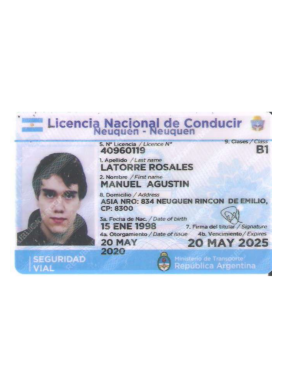

In [16]:
###################################################################
### SHOW MOST CONFIDENT DOCUMENTS WHICH SURPASSES THE THRESHOLD ###
###################################################################

for result in docs_with_max_confidence:
  for class_name, pdf_confidences in result.items():
    for pdf_path, confidence in pdf_confidences.items():
      if confidence >= threshold:
        print("El documento de tipo ", class_name.upper(), "es:" ,pdf_path ,"(confianza: ",confidence,")")
      else:
        print("No se encontro documento con suficiente confianza de tipo ", class_name.upper()," el mas parecido es: ", pdf_path ,"(confianza: ",confidence,")")
        print("Previsualizacion de",pdf_path)
        preview(pdf_path)

        # todo Ventana con texto de que no se pudo clasificar a PDF Path. 
        # todo Boton preview
        # todo Boton de seleccion de clase manual
        # todo Hacer una estructura con los nombres de las clases y los pdf asignados
        # todo Ingreso de archivos PDF y los JSON de palabras clave
      

In [76]:
def preview(pdf_path, page_number=0):
    pages = convert_from_path(pdf_path, first_page=page_number + 1, last_page=page_number + 1)
    # Show image
    plt.imshow(pages[0])
    plt.axis('off')
    plt.show()

preview('doble.pdf', 0)

In [ ]:
#########################
### SHOW FULL RESULTS ###
#########################
print("RESULTADOS DEL ANALISIS DEL DOCUMENTO")
pprint(results) 

RESULTADOS DEL ANALISIS DEL DOCUMENTO
[{'dni': {'/home/manuel/bacssa/orm/Documento_ITA.pdf': 0.9769230769230768,
          '/home/manuel/bacssa/orm/doble.pdf': 1.0,
          '/home/manuel/bacssa/orm/licecond.pdf': 0.038461538461538464}},
 {'licencia_conducir': {'/home/manuel/bacssa/orm/Documento_ITA.pdf': 0.05,
                        '/home/manuel/bacssa/orm/doble.pdf': 0.07333333333333333,
                        '/home/manuel/bacssa/orm/licecond.pdf': 0.8633333333333334}}]


In [ ]:
########################################################
### SHOW ALL DOCUMENTS WHICH SURPASSES THE THRESHOLD ###
########################################################
filtered_results = []
for doc in results:
    filtered_doc = {}
    for doc_type, pdfs in doc.items():
        filtered_pdfs = {pdf: confidence for pdf, confidence in pdfs.items() if confidence > threshold}
        filtered_doc[doc_type] = filtered_pdfs
    filtered_results.append(filtered_doc)

print("RESULTADOS DEL ANALISIS DEL DOCUMENTO")
pprint(filtered_results)

RESULTADOS DEL ANALISIS DEL DOCUMENTO
[{'dni': {'/home/manuel/bacssa/orm/Documento_ITA.pdf': 0.9769230769230768,
          '/home/manuel/bacssa/orm/doble.pdf': 1.0}},
 {'licencia_conducir': {'/home/manuel/bacssa/orm/licecond.pdf': 0.8633333333333334}}]


In [ ]:
##################################################
### RESTRUCTURES THE DATA TO SHOWN             ###
### THE CONFIDENCE OF EVERY KEYWORD SET BY PDF ###
##################################################
def restructure_json(data):
    result = {}

    # Itera sobre las clases y sus respectivas confianzas
    for entry in data:
        for class_name, files in entry.items():
            # Itera sobre los archivos de cada clase
            for file_path, confidence in files.items():
                # Si el archivo no está en el resultado, agrega una nueva entrada para él
                if file_path not in result:
                    result[file_path] = {}

                # Asocia la clase y la confianza con el archivo
                result[file_path][class_name] = confidence
    
    return result

restructured_data = restructure_json(results)

#
pprint(restructured_data)

{'/home/manuel/bacssa/orm/Documento_ITA.pdf': {'dni': 0.9769230769230768,
                                               'licencia_conducir': 0.05},
 '/home/manuel/bacssa/orm/doble.pdf': {'dni': 1.0,
                                       'licencia_conducir': 0.07333333333333333},
 '/home/manuel/bacssa/orm/licecond.pdf': {'dni': 0.038461538461538464,
                                          'licencia_conducir': 0.8633333333333334}}
